In [1]:
from dotenv import dotenv_values, find_dotenv
from pathlib import Path

config = dotenv_values(find_dotenv(".env"))
data_root_dir = Path(config["DATA_ROOT_DIR"]) / "ISIC_2019_Training_Input"

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import missingno as msno

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
%matplotlib inline 

meta_data_dir = "../archive/"

In [3]:
meta_data = pd.read_csv(data_root_dir / "ISIC_2019_Training_Metadata.csv")
melanoma_classes = pd.read_csv(data_root_dir / "ISIC_2019_Training_GroundTruth.csv")
merged = pd.merge(meta_data, melanoma_classes, how="inner", on="image")

In [4]:
merged.head()

image  age_approx anatom_site_general lesion_id     sex  MEL   NV  \
0  ISIC_0000000        55.0      anterior torso       NaN  female  0.0  1.0   
1  ISIC_0000001        30.0      anterior torso       NaN  female  0.0  1.0   
2  ISIC_0000002        60.0     upper extremity       NaN  female  1.0  0.0   
3  ISIC_0000003        30.0     upper extremity       NaN    male  0.0  1.0   
4  ISIC_0000004        80.0     posterior torso       NaN    male  1.0  0.0   

   BCC   AK  BKL   DF  VASC  SCC  UNK  
0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0   0.0  0.0  0.0

### Presence of missing values 

<AxesSubplot: >

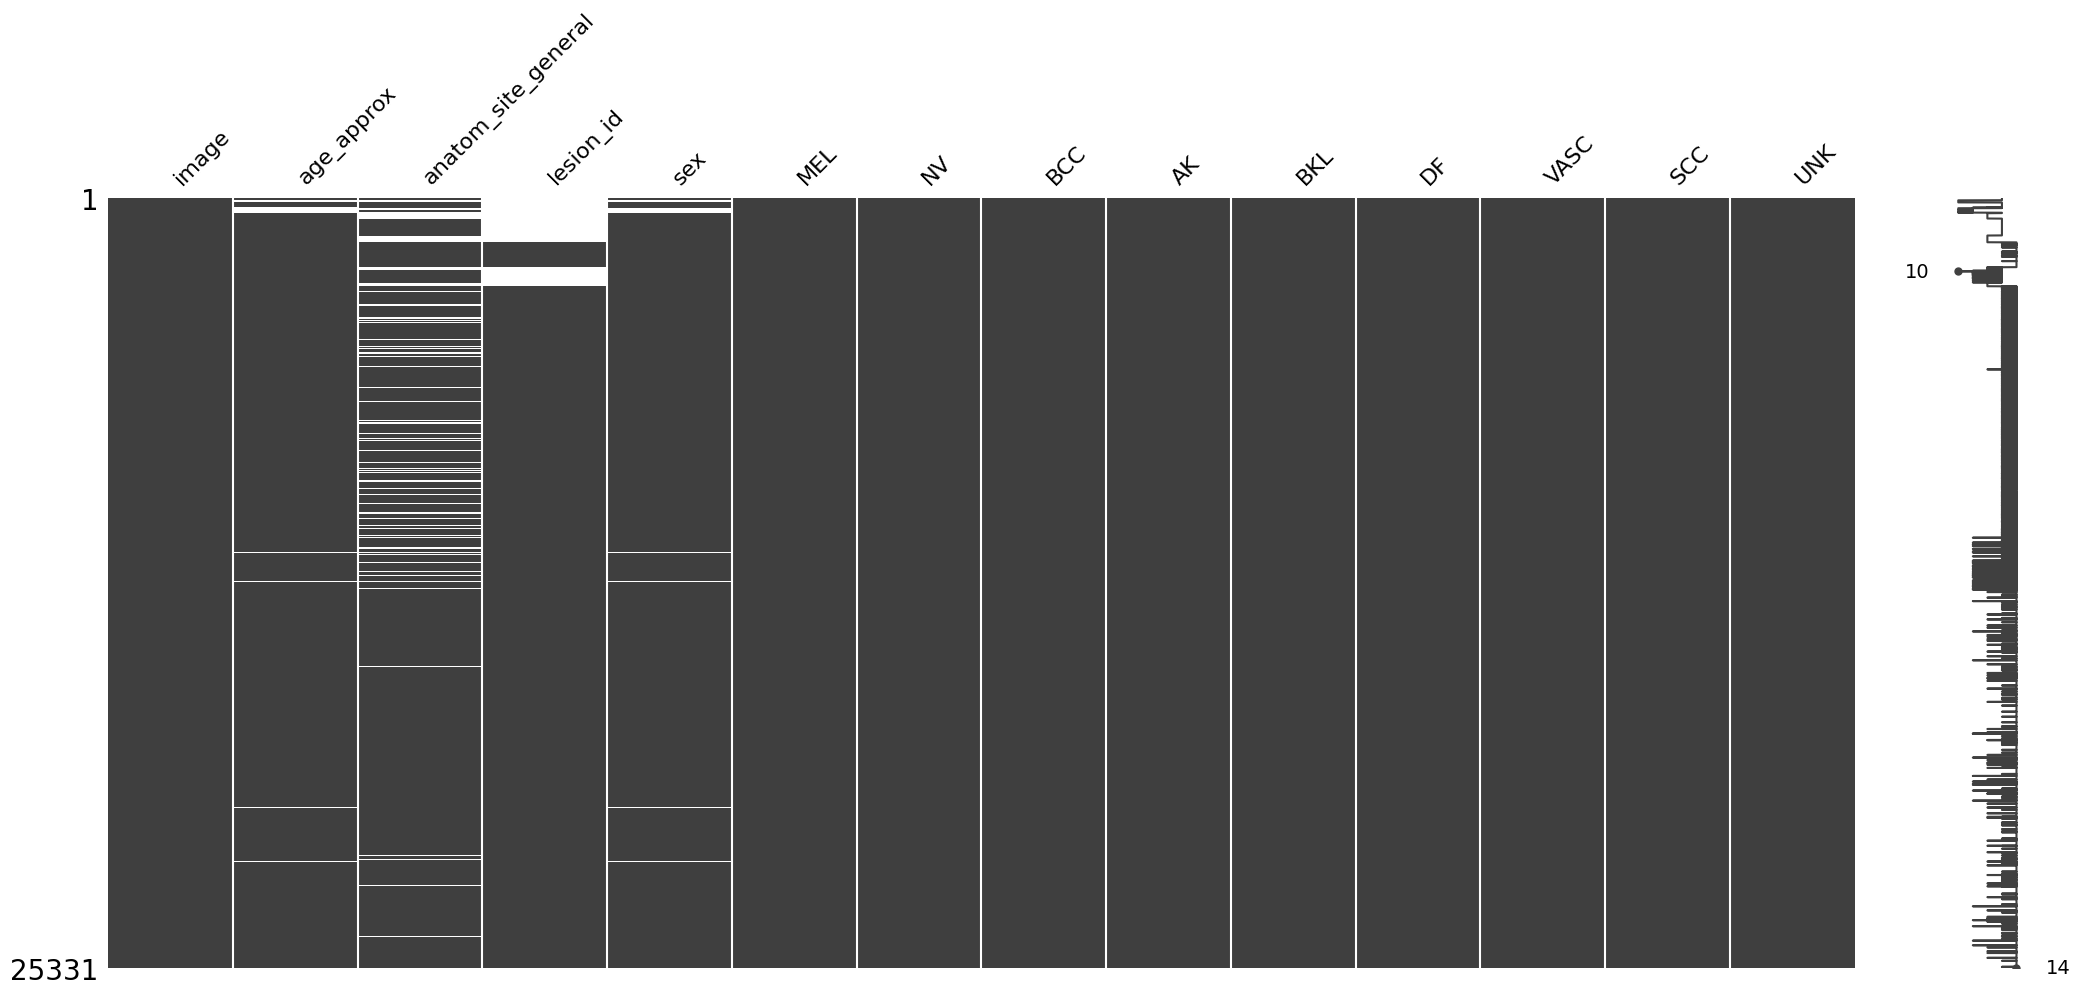

In [5]:
msno.matrix(merged)

In [6]:
# Shared data between plots
cmap = px.colors.qualitative.Pastel

sexes = meta_data["sex"].dropna().unique()
locations = meta_data["anatom_site_general"].dropna().unique()
labels = [x for x in melanoma_classes.columns if x not in ["image"]]
merged["label"] = merged[labels].idxmax(1)


In [7]:
merged.anatom_site_general.value_counts()

anterior torso     6915
lower extremity    4990
head/neck          4587
upper extremity    2910
posterior torso    2787
palms/soles         398
oral/genital         59
lateral torso        54
Name: anatom_site_general, dtype: int64

In [8]:
melanoma_classes.sum()[1:].to_frame()

0
MEL    4522.0
NV    12875.0
BCC    3323.0
AK      867.0
BKL    2624.0
DF      239.0
VASC    253.0
SCC     628.0
UNK       0.0

In [9]:
merged[['anatom_site_general', *labels]].groupby(['anatom_site_general'], as_index=False).sum()

anatom_site_general     MEL      NV     BCC     AK     BKL     DF  VASC  \
0      anterior torso  1331.0  3699.0  1114.0   92.0   445.0   43.0  78.0   
1           head/neck   880.0   767.0  1131.0  598.0  1001.0    0.0  36.0   
2       lateral torso    14.0    34.0     0.0    0.0     6.0    0.0   0.0   
3     lower extremity   796.0  2876.0   462.0   66.0   412.0  138.0  58.0   
4        oral/genital    19.0    24.0     0.0    0.0    14.0    0.0   2.0   
5         palms/soles   201.0   168.0     0.0    6.0     7.0    0.0   3.0   
6     posterior torso   430.0  1888.0   186.0    4.0   230.0    2.0  22.0   
7     upper extremity   724.0  1325.0   358.0   79.0   234.0   52.0  23.0   

     SCC  UNK  
0  113.0  0.0  
1  174.0  0.0  
2    0.0  0.0  
3  182.0  0.0  
4    0.0  0.0  
5   13.0  0.0  
6   25.0  0.0  
7  115.0  0.0

In [25]:
location_to_age_fig = make_subplots(
    rows=sexes.shape[0],
    cols=1,
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)

for sex in sexes:
    for color_id, location in enumerate(locations):
        filtered = (meta_data["anatom_site_general"] == location) & (
            meta_data["sex"] == sex
        )
        row = np.where(meta_data["sex"].unique() == sex)[0][0] + 1
        location_to_age_fig.add_trace(
            go.Violin(
                x=meta_data["anatom_site_general"][filtered],
                y=meta_data["age_approx"][filtered],
                name=location,
                box_visible=True,
                meanline_visible=True,
                legendgroup=sex,
                showlegend=False,
                line=dict(width=2, color=cmap[color_id]),
                marker=dict(color=cmap[color_id]),
            ),
            row=row,
            col=1,
        )

location_to_age_fig.update_yaxes(title="Age")
location_to_age_fig.update_layout(
    yaxis_zeroline=False,
    title_text="Nevus location distribution with regard to age and sex",
    title_x=0.5,
    height=800,
    width=1400,
)
location_to_age_fig.show()

In [26]:
label_to_age_fig = make_subplots(
    rows=sexes.shape[0],
    cols=1,
    horizontal_spacing=0.1,
    vertical_spacing=0.1,
)

for sex in sexes:
    for color_id, label in enumerate(labels):
        filtered = (merged["label"] == label) & (merged["sex"] == sex)
        row = np.where(merged["sex"].unique() == sex)[0][0] + 1
        label_to_age_fig.add_trace(
            go.Violin(
                x=merged["label"][filtered],
                y=merged["age_approx"][filtered],
                name=label,
                box_visible=True,
                meanline_visible=True,
                legendgroup=sex,
                showlegend=False,
                line=dict(width=2, color=cmap[color_id]),
                marker=dict(color=cmap[color_id]),
            ),
            row=row,
            col=1,
        )

label_to_age_fig.update_yaxes(title="Age")
label_to_age_fig.update_layout(
    yaxis_zeroline=False,
    title_text="Nevus type distribution with regard to age and sex",
    title_x=0.5,
    height=800,
    width=1400,
)
label_to_age_fig.show()

In [11]:
age_to_lcoation_plot = go.Figure()

for site in meta_data["sex"].unique():
    age_to_lcoation_plot.add_trace(
        go.Histogram(
            x=meta_data[meta_data["sex"] == site].anatom_site_general,
            histnorm="percent",
            name=site,
        )
    )
age_to_lcoation_plot.update_layout(
    title_x=0.5,
    title_text="Lesion location distribution with regard to patient's sex",
    xaxis_title_text="Location per sex",
    yaxis_title_text="Count",
    bargap=0.2,
    bargroupgap=0.1,
)
age_to_lcoation_plot.show()

In [12]:
location_to_label_fig = make_subplots(
    rows=len(labels),
    cols=sexes.shape[0],
    subplot_titles=[f"{sex} : {l}" for l in labels for sex in sexes],
    horizontal_spacing=0.05,
    vertical_spacing=0.05,
)

for sex_id, sex in enumerate(sexes):
    for label_id, label in enumerate(labels):
        for location in locations:

            filtered = (
                (merged["anatom_site_general"] == location)
                & (merged["sex"] == sex)
                & (merged["label"] == label)
            )

            location_to_label_fig.add_trace(
                go.Histogram(
                    x=merged["age_approx"][filtered].to_numpy(),
                    xbins=dict(start=0, end=110, size=5),
                    name=f"{sex} {location} {label}",
                    legendgroup=f"{location}",
                ),
                row=label_id + 1,
                col=sex_id + 1,
            )

location_to_label_fig.update_xaxes(title="Age")
location_to_label_fig.update_yaxes(title="Bin count")
location_to_label_fig.update_layout(
    title_text="Per nevi-type age distribution with regard to location and sex",
    title_x=0.5,
    height=1600,
    width=1500,
)
location_to_label_fig.show()